<a href="https://colab.research.google.com/github/RohitGanji/bitcoin-price-prediction/blob/main/Bitcoin_Price_Prediction_using_Multivariate_Time_Series_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bitcoin Price Prediction using Multivariate Time Series Data

The goal of this notebook is to predict the Bitcoin Price 💰📈
<br><br>
**Univariate Time Series:** Time Series that consists of single observations recorded sequentially over equal time increments. (Single column in pandas dataframe)

**Multivariate Time Series:** Time Series that consists of more than one observations recorded sequentially over equal time increments. (Multiple columns in pandas dataframe)

| Univarite | Multivariate |
| ----- | ----- |
| Single observation | Multiple observations |
-
<br>
We're going to use the historical Bitcoin price data and Bitcoin block reward size as our dataset.

> **Note:** This is not a financial advice. I am not responsible if you make financial decisions based on this model's predictions. Time Series forecasting for market prices is terrible.

In [2]:
import pandas as pd
import numpy as np

## Preprocess Data

Let's create Multivariate Time Series Data with:

1. Bitcoin Historical Prices
2. Bitcoin Block Reward values

### Importing Bitcoin Historical Data

You can find the historical data from [Coindesk](https://www.coindesk.com/price/bitcoin).<br><br>
<img src="https://github.com/RohitGanji/bitcoin-price-prediction/raw/main/bitcoin-prices.png" width="400"/><br>**Note:** Click on `all` and click on `EXPORT DATA` to download the data.
I'll be using the data as of `21/08/2021`. You can download the CSV file from my [GitHub](https://github.com/RohitGanji/bitcoin-price-prediction) alternatively.

In [3]:
# Download the data from GitHub
!wget -q https://github.com/RohitGanji/bitcoin-price-prediction/raw/main/BTC_USD_2013-10-01_2021-08-21-CoinDesk.csv

Here is a sample of our data.

<img src="https://github.com/RohitGanji/bitcoin-price-prediction/raw/main/df-head.png" width="75%"/>

Let's import our data. As the data is in CSV format, let's use pandas `read_csv()` function. 

We'll only be needing the `Closing Price (USD)` prices for our model. And as our data has a date component, let's parse the dates using `parse_dates` parameter.

In [4]:
# Import the data with pandas
import pandas as pd

btc = pd.read_csv("/content/BTC_USD_2013-10-01_2021-08-21-CoinDesk.csv",
                 parse_dates=["Date"], index_col="Date",
                 usecols=["Date", "Closing Price (USD)"])
btc.columns = ["Price"]
btc.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


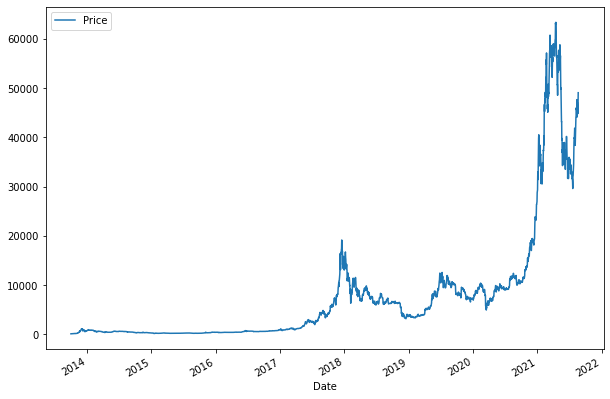

In [5]:
btc.plot(figsize=(10,7));

### Adding Block Reward values

You can find the historical data for Bitcoin Block reward halfing dates and values [here](https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving).<br><br>

| Block Reward | Start Date | End Date |
| ----- | ----- | ----- |
| 25 | 2012-11-28 | 2016-08-08 |
| 12.5 | 2016-07-09 | 2020-05-10 |
| 6.25 | 2020-05-11 | TBA (2024) |

<br>Let's manually add this data as a new column.

In [6]:
import numpy as np

# Block Rewards
reward_1 = 25.0
reward_2 = 12.5
reward_3 = 6.25

# Block reward dates
reward_1_date = np.datetime64("2012-11-28")
reward_2_date = np.datetime64("2016-07-09")
reward_3_date = np.datetime64("2020-05-11")

Let's get the days for each reward block values.

In [7]:
# Block reward days
reward_2_days = (reward_2_date - btc.index[0]).days
reward_3_days = (reward_3_date - btc.index[0]).days

reward_2_days, reward_3_days

(1012, 2414)

Now let's add another column `Reward` to our data.

In [8]:
btc["Reward"] = None

# Set values of Reward column
btc.iloc[:reward_2_days, -1] = reward_1
btc.iloc[reward_2_days:reward_3_days, -1] = reward_2
btc.iloc[reward_3_days:, -1] = reward_3

We've added a new column to our data. Let's see what it looks like.

In [9]:
btc.head()

,Price,Reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


### Visualizing Data

Let's visualize our data

In [10]:
from sklearn.preprocessing import minmax_scale

btc_scaled = pd.DataFrame(minmax_scale(btc[["Price", "Reward"]]),
                          columns = btc.columns,
                          index = btc.index)

btc_scaled.head()

,Price,Reward
Date,,
2013-10-01,0.000238,1.0
2013-10-02,0.000267,1.0
2013-10-03,0.000000,1.0
2013-10-04,0.000160,1.0
2013-10-05,0.000202,1.0


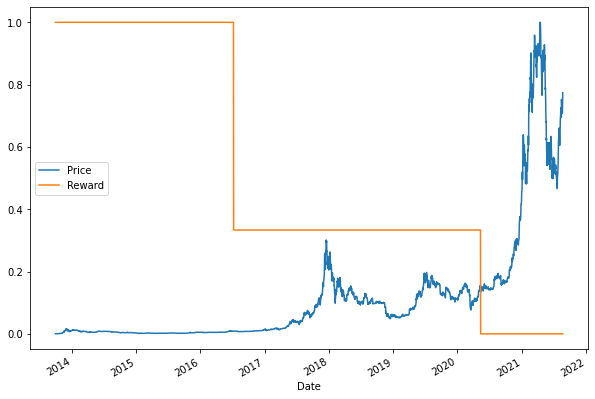

In [11]:
btc_scaled.plot(figsize=(10,7));

After scaling, we can conclude that the price of the Bitcoin increases as the Block Reward value decreases. This could be a vital information that could affect our model's performance.

## Create Dataset

In [12]:
HORIZON = 1
WINDOW_SIZE = 7

btc_windowed = btc.copy()

for i in range(WINDOW_SIZE):
  btc_windowed[f"Price+{i+1}"] = btc_windowed[f"Price"].shift(periods=i+1)

btc_windowed.head(10)

,Price,Reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [13]:
X = btc_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = btc_windowed.dropna()["Price"].astype(np.float32)
X.head()

,Reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [14]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [15]:
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size].values, y[:split_size].values
X_test, y_test = X[split_size:].values, y[split_size:].values
len(X_train), len(y_train), len(X_test), len(y_test)

(2299, 2299, 575, 575)

In [16]:
X_train[:5], y_train[:5]

(array([[ 25.     , 121.795  , 120.65533, 121.33866, 118.67466, 108.58483,
         125.455  , 123.65499],
        [ 25.     , 123.033  , 121.795  , 120.65533, 121.33866, 118.67466,
         108.58483, 125.455  ],
        [ 25.     , 124.049  , 123.033  , 121.795  , 120.65533, 121.33866,
         118.67466, 108.58483],
        [ 25.     , 125.96116, 124.049  , 123.033  , 121.795  , 120.65533,
         121.33866, 118.67466],
        [ 25.     , 125.27966, 125.96116, 124.049  , 123.033  , 121.795  ,
         120.65533, 121.33866]], dtype=float32),
 array([123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ],
       dtype=float32))

## Modeling

In [17]:
import tensorflow as tf
from keras import layers

model = tf.keras.Sequential([
  # layers.LSTM(60, input_shape=(8,2)), #Using this layers is strangely giving a val_loss of 24000+
  layers.Dense(256, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(16, activation="linear"),
  layers.Dense(HORIZON)
])

# Compile
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["mae", "mse"])

# Fit
model.fit(X_train, y_train,
          epochs=100, verbose=0,
          validation_data=(X_test, y_test),
          callbacks=[tf.keras.callbacks.ModelCheckpoint("model",
                                                        verbose=0,
                                                        save_best_only=True)])

INFO:tensorflow:Assets written to: model/assets
INFO:tensorflow:Assets written to: model/assets
INFO:tensorflow:Assets written to: model/assets
INFO:tensorflow:Assets written to: model/assets
INFO:tensorflow:Assets written to: model/assets
INFO:tensorflow:Assets written to: model/assets
INFO:tensorflow:Assets written to: model/assets
INFO:tensorflow:Assets written to: model/assets
INFO:tensorflow:Assets written to: model/assets
INFO:tensorflow:Assets written to: model/assets
INFO:tensorflow:Assets written to: model/assets
INFO:tensorflow:Assets written to: model/assets
INFO:tensorflow:Assets written to: model/assets


In [18]:
model = tf.keras.models.load_model("model")
model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 730.0288 - mae: 730.5285 - mse: 1535852.2500


[730.02880859375, 730.5285034179688, 1535852.25]

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2304      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 19,809
Trainable params: 19,809
Non-trainable params: 0
_________________________________________________________________


## Prediction

In [83]:
preds = tf.squeeze(model.predict(X_test), axis=-1).numpy()
preds.shape

(575,)

In [108]:
pred_data = pd.DataFrame(preds,columns=["Price"], index=btc[-len(X_test):].index)

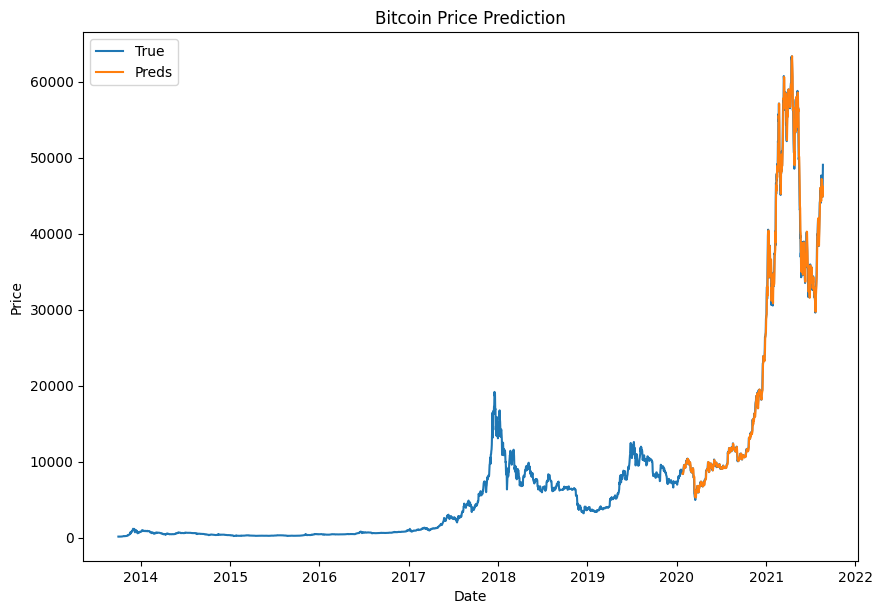

In [123]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7), dpi=100)
plt.plot(btc.Price, label="True")
plt.plot(pred_data, label="Preds")
plt.title("Bitcoin Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show();